# Benchmarking Learning Rate Transfer

[Yang et al.](https://arxiv.org/pdf/2203.03466) demonstrated muP parameter transfer's effectiveness in scaling hyperparameters from base models to larger variants, reducing the total FLOPs needed to train these models. Recently, [Everett et al.](https://arxiv.org/pdf/2407.05872v2) identified techiniques to enable hyperparameter transfer to other parameterizations. This work attempts to reproduce their findings and explore its limits.
  
## Experiments

I performed parameter scaling from 13m and 37m base models up to 1b models, comparing against SP without parameter scaling and muP baselines.

### Setup

Base model configurations:

- [13m base fully aligned exponent scaling](https://github.com/clankur/muGPT/blob/526bc268907b0aadc86bef5aea8ff65df562f20b/configs/c4_a100x8x4_13m.yaml)
- [37m base fully aligned exponent scaling](https://github.com/clankur/muGPT/blob/526bc268907b0aadc86bef5aea8ff65df562f20b/configs/c4_a100x8x4_37m.yaml)

Parameter transfer was applied to [270m](https://github.com/clankur/muGPT/blob/526bc268907b0aadc86bef5aea8ff65df562f20b/configs/c4_a100x8x4_270m.yaml) and [1b](https://github.com/clankur/muGPT/blob/526bc268907b0aadc86bef5aea8ff65df562f20b/configs/c4_a100x8x4_1b.yaml) models. Models used tuned gammas from hyperparameter optimization and zero initialization for queries and unembeddings. Implementation also used Adamatan2 modification described in the paper.



### Findings

At 270m, parameter scaling with fully aligned exponents consistently outperformed both the SP baseline and slightly exceeded muP implementation.

[Interactable 270m model comparison plots](https://app.clear.ml/projects/c6c821d0a24e402eb4879dbe3ce93e2b/compare-experiments;ids=df7e20341b944c7685fcc054975aa21c,b85c64948d2747799e141fe99d41efa8,1151de73c92c49baaa612fd2a1567ed8/scalars/graph)

In [2]:
from plot_helper import *

Plotting Loss...


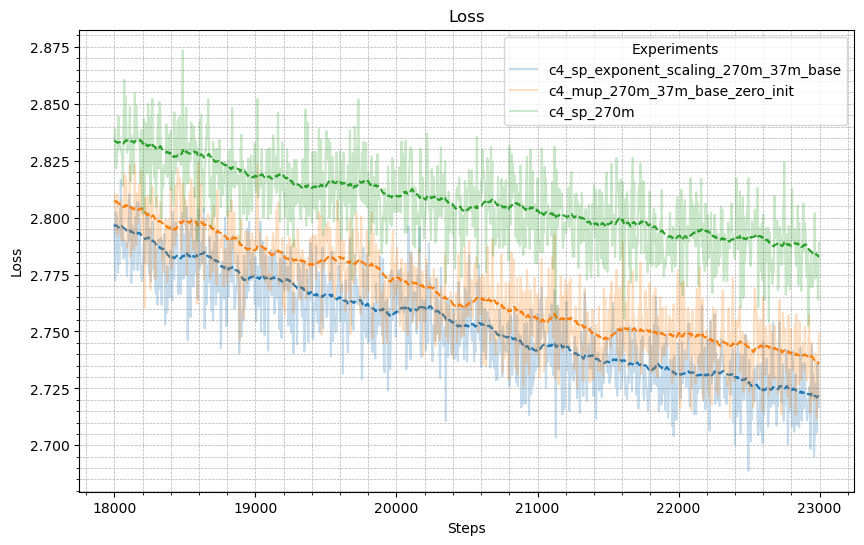

In [3]:
model_270m_task_ids = [
    "df7e20341b944c7685fcc054975aa21c",
    "b85c64948d2747799e141fe99d41efa8",
    "1151de73c92c49baaa612fd2a1567ed8"
]

loss_data_270m = get_metrics(model_270m_task_ids)
plot_all_metrics(loss_data_270m, plot_last=1000)

At 1B, parameter scaling approaches only surpassed baseline SP in the final 10k steps, with fully aligned exponent scaling maintaining superior performance.

[Interactable 1b model comparison plots](https://app.clear.ml/projects/*/compare-experiments;ids=b9044d8fd148453ab592d8839615f78f,95b1306d3bf243a4a601d41f2fd40760,8ba8cdbca4094bab8a458e9416fc97be/scalars/graph)

**Note:** Interactive plots require a ClearML account.



Plotting Loss...


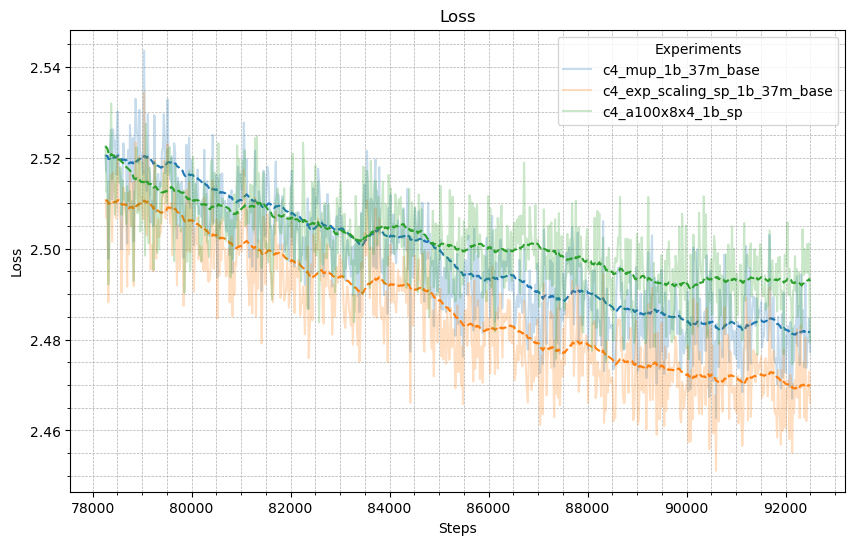

In [5]:
model_1b_task_ids = [
    "b9044d8fd148453ab592d8839615f78f",
    "95b1306d3bf243a4a601d41f2fd40760",
    "8ba8cdbca4094bab8a458e9416fc97be",
]

loss_data_1b = get_metrics(model_1b_task_ids)
plot_all_metrics(loss_data_1b, plot_last=750)

Final loss for each model.

### Model Type: 270M
| Model                              | Loss     |
|------------------------------------|----------|
| 270m, base 37m SP w/ fully aligned exponents and optimal constants  | 2.72389  |
| 270m, base 37m muP                            | 2.73995  |
| 270m SP                                       | 2.78688  |

### Model Type: 1B
| Model                              | Loss     |
|------------------------------------|----------|
| 1b, base 37m SP w/ fully aligned exponents and optimal constants      | 2.47100  |
| 1b, base 37m muP                               | 2.48275  |
| 1b SP                                          | 2.49312  |

## Pending questions

### Alternative parameterization approaches

Future work would include implementing NTK and benchmarking its parameterizations' performance, as Everett et al. found that it was the best model when applying per-layer unaligned exponents.

### Alignment

Further investigation needed into alignment impact. Everett et al. found unaligned exponents achieve lower loss but also have weaker learning rate scaling behavior. They also note that fully-aligned exponents have their own scaling issues and generally find that that unaligned exponents are preferable.

### Limits to parameter scaling

Parameter scaling effectiveness appears dependent on base model architecture - 13m base (head dim 32) underperformed benchmark SP at 270m scale, while 37m base (head dim 64) outperformed it. This suggests a minimum head dimension of 64 for successful parameter transfer.
